## Strain Mapping of Percipitate in ZrNb

This notebook goes through the steps to calculate the strain using pyxem.  This data was taken from the paper:

```
Microstructure and microchemistry study of irradiation-induced precipitates in proton irradiated ZrNb alloys
Yu, Zefeng; Zhang, Chenyu; Voyles, Paul M.; He, Lingfeng; Liu, Xiang; Nygren, Kelly; Couet, Adrien
10.18126/2nj3-gyd8 
```

It shows a percipitate which arises from irradiation in the ZrNb sample.  The dataset shows the strain for one of these precipitates.  The results in this notebook are slightly different than those published as the paper only uses two diffraction spots to calculate strain.  Here we define a `basis` set of diffraction spots from an unstrained region of the sample and then use that basis set of spots to refine the diffraction spots found in the rest of the dataset.

Then a gradient tensor which maps each set of found points at (x,y) is calculated such that the tensor maps the points onto the basis.

Transforming that gradient tensor we can plot the percent strain in the E11 E22 and E33 directions as well as a Theta displacement. 

In this sample you can see that there is mostly compressive stress on the percipite as well as shear stress. Hot spots on the edge of the theta map suggest the presence of dislocations as well. 

In [212]:
import pooch
file_path = pooch.retrieve(
    url="https://zenodo.org/record/8021874/files/ZrNbPercipitate.zspy",
    fname="ZrNbPercipitate.zspy",
    path="./data/",
    known_hash="4586330f8bb932f7f8422a3603969ac0f38d16a4978eed6529038c53f8b06f6e"
)

Updating data from 'https://zenodo.org/record/8021874/files/ZrNbPercipitate.zspy' to file '/srv/home/csfrancis/4d_STEM/4D STEM rawdata/data/ZrNbPercipitate.zspy'.


In [213]:
import hyperspy.api as hs
import zarr

In [214]:
store = zarr.ZipStore("data/ZrNbPercipitate.zspy")
s = hs.load(store, lazy=True)

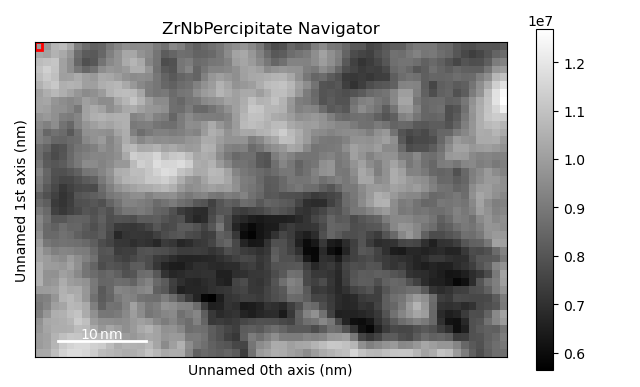

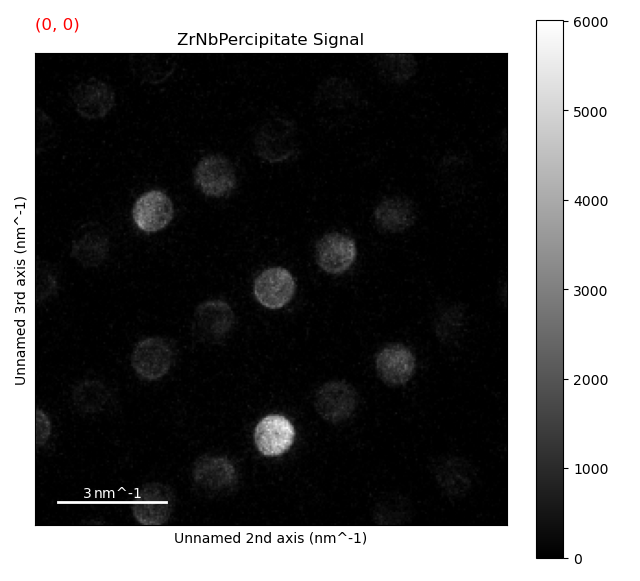

In [215]:
s.plot()

## Subtracting the Background

Let's subtract the background using the difference of gaussians function.  This acts as a spatial bandpass filter where features with a radius less than `sqrt(2)*min_sigma` and features larger than `sqrt(2)*max_sigma` are supressed. 

If we are trying to find disks of a known size we can use this function fairly liberally.

In [83]:
sub = s.subtract_diffraction_background("difference of gaussians", min_sigma=4, max_sigma=15)

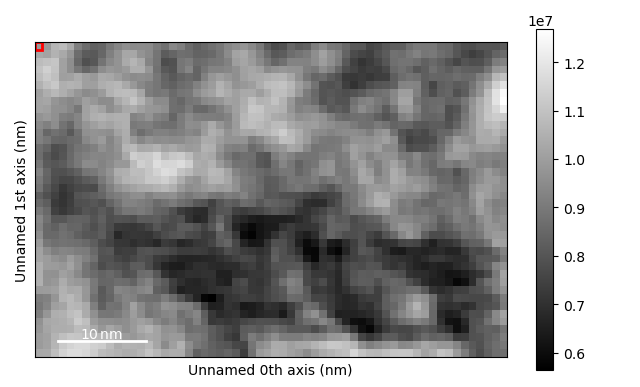

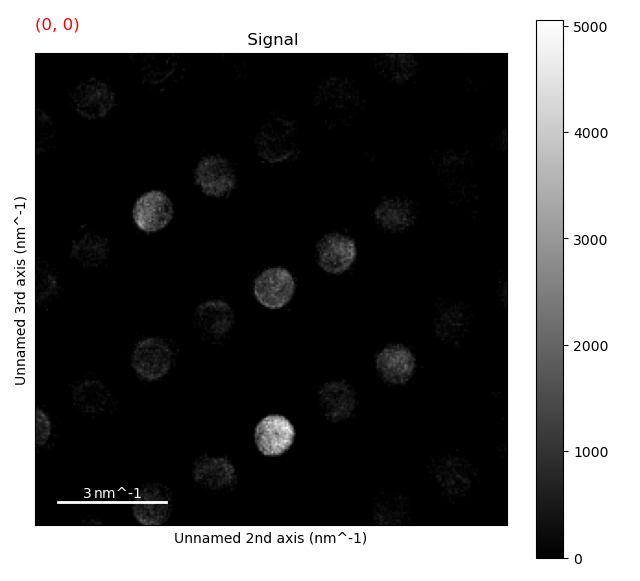

In [85]:
sub.navigator= s.navigator # pass through for speed of plotting
sub.plot()

## Filtering with a Disk Template Matching

Then we can use template matching before finding the diffraction vectors in the dataset.  I like to do this lazily and then adjust the parameters.  The disk_r can be read from the size of the direct beam but it is also good to view the template result to make sure that things worked correctly.  If your disk_r is too small you might end up with a valley at the center of the disk and if your radius is too large you end up with a platau at the center.

This is shown below where the ideal radius is around ~11 pixels

[<Axes: title={'center': 'Radius=5pix'}>,
 <Axes: title={'center': 'Radius=10pix'}>,
 <Axes: title={'center': 'Radius=15pix'}>]

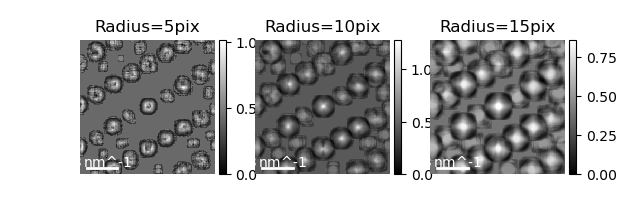

In [93]:
one_pattern=sub.inav[5,5]
hs.plot.plot_images([one_pattern.template_match_disk(r) for r in [5,10,15]], 
                    axes_decor="off",
                    scalebar="all",
                    label=["Radius=5pix","Radius=10pix","Radius=15pix"])

In [94]:
temp = sub.template_match_disk(disk_r=11)

In [96]:
temp.navigator= s.navigator # passing the navigator again

## Peak Finding 

Now we can see what a good value for peak finding is.  We can either use the interactive peak finding in hyperspy but I tend to just play with the vmin value with plotting until I get a reasonable min value.

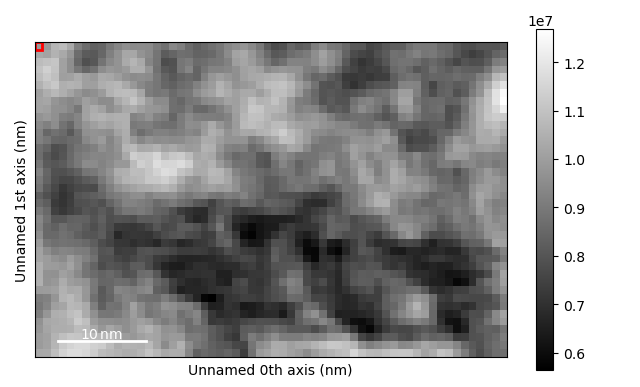

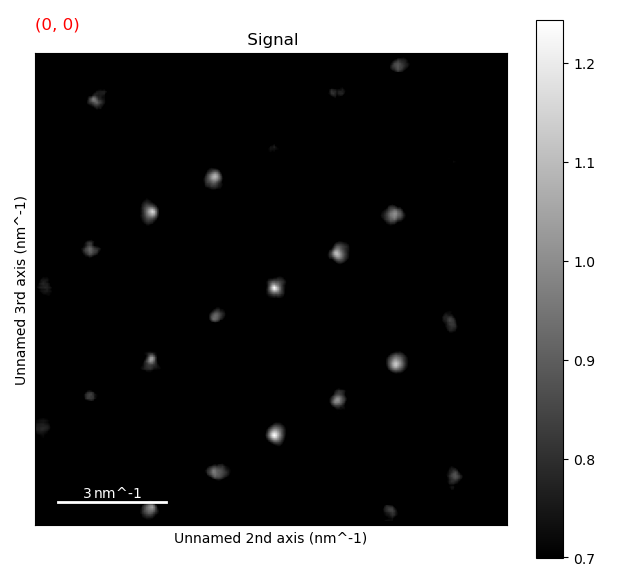

In [100]:
%matplotlib widget
temp.plot(vmin=.7)

In [106]:
peaks = temp.find_peaks(threshold_abs=0.7,
                        distance=10,
                        interactive=False)

[########################################] | 100% Completed | 18.64 s


In [107]:
from pyxem.signals import DiffractionVectors

In [108]:
sig_axs = temp.axes_manager.signal_axes
cal = [s.scale for s in sig_axs]
center = [-s.offset/s.scale for s in sig_axs]

In [109]:
center

[128.0, 128.0]

In [110]:
vect = DiffractionVectors.from_peaks(peaks, center=center, calibration=cal)

[########################################] | 100% Completed | 102.14 ms


## Setting a Basis and Determining Strain

First we filter the vactors based on their magnitude. This gets rid of the zero beam and weaker peaks farther out!

In [ ]:
vect = vect.filter_magnitude(min_magnitude=1., max_magnitude=6.)

Defining the basis vector far from the region of interest

In [179]:
basis = vect.inav[3,4]

Show the number of vectors at every position.  You at least need 2 vectors at every position for strain mapping but more is usually better as long as they are good quality peaks.

[########################################] | 100% Completed | 102.22 ms


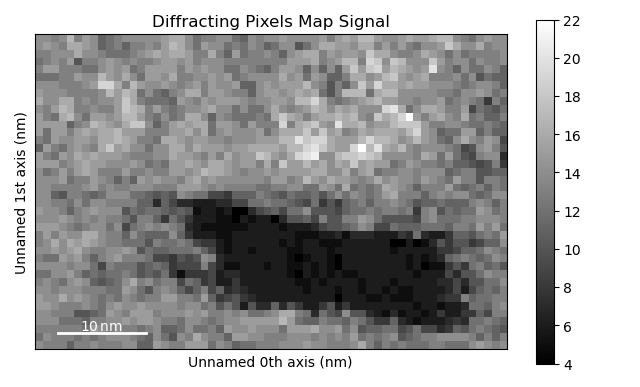

In [200]:
vect.get_diffracting_pixels_map().plot()

 Filter the vectors to only those vectors around a basis vector.  Distance defines the max distance from a basis point for some point to be associated with that point.
 
 If multiple points are found the closest point is used.  If no points are found `np.nan` is returned and it is ignored.

In [201]:
filtered_vectors = vect.filter_basis(basis.data[0], distance=.3, inplace= False)

[########################################] | 100% Completed | 202.98 ms


In [202]:
from pyxem.generators.displacement_gradient_tensor_generator import get_DisplacementGradientMap

In [203]:
strain_map = get_DisplacementGradientMap(filtered_vectors, basis.data[0])

[########################################] | 100% Completed | 325.16 ms


In [204]:
maps = strain_map.get_strain_maps()

[########################################] | 100% Completed | 204.31 ms
[########################################] | 100% Completed | 101.87 ms
[########################################] | 100% Completed | 102.09 ms


In [205]:
# Small bug! These axes are copied over so we do this manually
maps.axes_manager.signal_axes[0].scale =s.axes_manager.navigation_axes[0].scale
maps.axes_manager.signal_axes[1].scale =s.axes_manager.navigation_axes[1].scale
maps.axes_manager.signal_axes[0].units =s.axes_manager.navigation_axes[0].units
maps.axes_manager.signal_axes[1].units =s.axes_manager.navigation_axes[1].units


## Visualizing the Strain

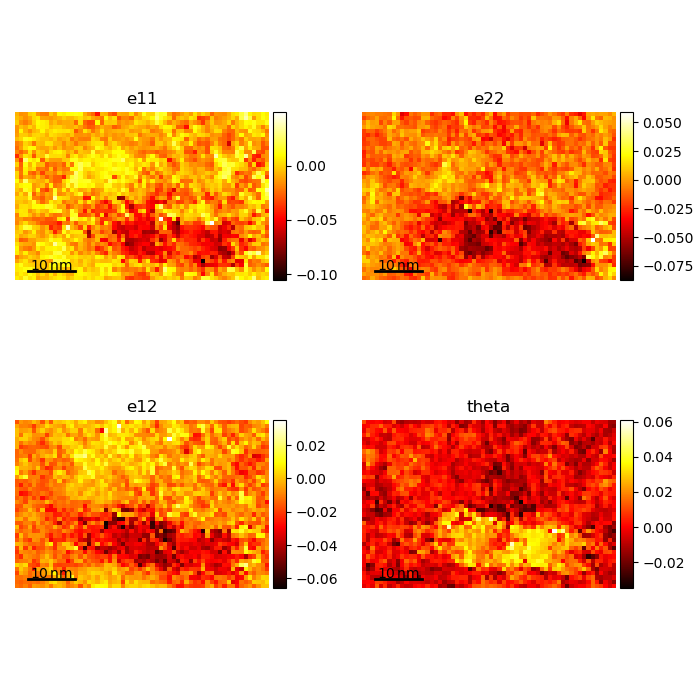

In [199]:
import matplotlib.pyplot as plt
f= plt.figure(figsize=(7,7))
hs.plot.plot_images(maps,per_row=2,fig=f,
                    label=["e11","e22", "e12", "theta"],
                    tight_layout=True, cmap="hot", axes_decor="off", scalebar="all", scalebar_color="black")
plt.show()